# Projekt Terawatt

Simulation der Systemdelays am Energiecampus.

In [1]:
import iplantuml

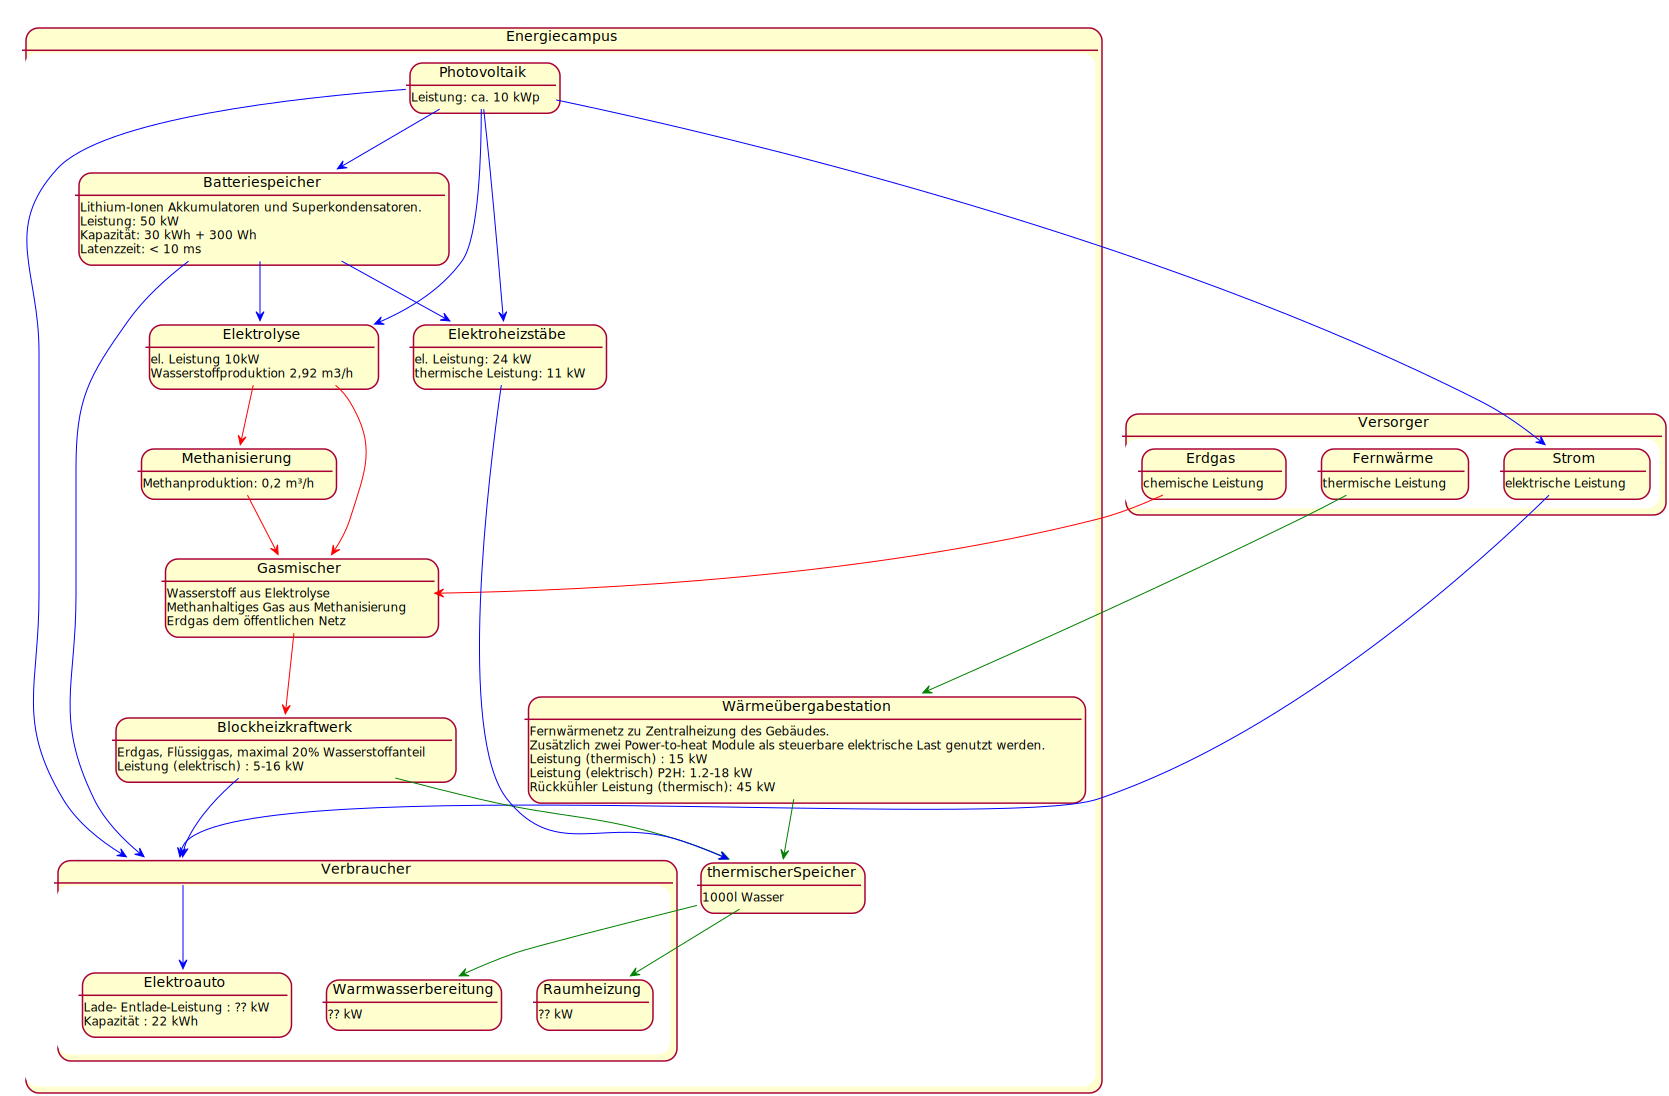

In [2]:
%%plantuml

@startuml


state Energiecampus{
    Gasmischer : Wasserstoff aus Elektrolyse
    Gasmischer : Methanhaltiges Gas aus Methanisierung
    Gasmischer : Erdgas dem öffentlichen Netz
    Wärmeübergabestation : Fernwärmenetz zu Zentralheizung des Gebäudes. 
}

state Versorger{
    Strom -[#blue]-> Verbraucher 
    Strom : elektrische Leistung
    Erdgas -[#red]-> Gasmischer
    Erdgas : chemische Leistung
    Fernwärme -[#green]-> Wärmeübergabestation
    Fernwärme : thermische Leistung
}

state Energiecampus{
    
    state Verbraucher {
        Elektroauto : Lade- Entlade-Leistung : ?? kW
        Elektroauto : Kapazität : 22 kWh
        Raumheizung : ?? kW
        Warmwasserbereitung : ?? kW
    }                    
    
    Blockheizkraftwerk -[#green]-> thermischerSpeicher
    Blockheizkraftwerk -[#blue]-> Verbraucher
    Blockheizkraftwerk : Erdgas, Flüssiggas, maximal 20% Wasserstoffanteil
    Blockheizkraftwerk : Leistung (elektrisch) : 5-16 kW

    Gasmischer -[#red]-> Blockheizkraftwerk

    Wärmeübergabestation : Zusätzlich zwei Power-to-heat Module als steuerbare elektrische Last genutzt werden. 
    Wärmeübergabestation : Leistung (thermisch) : 15 kW
    Wärmeübergabestation : Leistung (elektrisch) P2H: 1.2-18 kW
    Wärmeübergabestation : Rückkühler Leistung (thermisch): 45 kW
    Wärmeübergabestation -[#green]-> thermischerSpeicher

    Batteriespeicher : Lithium-Ionen Akkumulatoren und Superkondensatoren. 
    Batteriespeicher : Leistung: 50 kW
    Batteriespeicher : Kapazität: 30 kWh + 300 Wh
    Batteriespeicher : Latenzzeit: < 10 ms
    Batteriespeicher -[#blue]-> Verbraucher
    Verbraucher -[#blue]-> Elektroauto

    Photovoltaik : Leistung: ca. 10 kWp
    Photovoltaik -[#blue]-> Strom
    Photovoltaik -[#blue]-> Verbraucher
    Photovoltaik -[#blue]-> Batteriespeicher
    Photovoltaik -[#blue]-> Elektrolyse
    Photovoltaik -[#blue]-> Elektroheizstäbe
                                                            
    Elektrolyse : el. Leistung 10kW
    Elektrolyse : Wasserstoffproduktion 2,92 m3/h
    Batteriespeicher -[#blue]-> Elektrolyse
    Elektrolyse -[#red]-> Gasmischer
    Elektrolyse -[#red]-> Methanisierung

    Methanisierung : Methanproduktion: 0,2 m³/h
    Methanisierung -[#red]-> Gasmischer

    thermischerSpeicher -[#green]-> Warmwasserbereitung
    thermischerSpeicher -[#green]-> Raumheizung
    thermischerSpeicher : 1000l Wasser

    Elektroheizstäbe : el. Leistung: 24 kW
    Elektroheizstäbe : thermische Leistung: 11 kW
    Elektroheizstäbe -[#blue]-> thermischerSpeicher
                                                                                
    Batteriespeicher -[#blue]-> Elektroheizstäbe
}

@enduml 

In [74]:
# globals.py
timestep = 1  # second

# basic.py
class Power:
    def __init__(self):
        self.chemical = 0
        self.thermal = 0
        self.electrical = 0
        self.solar = 0

class Energy:
    def __init__(self):
        self.chemical = 0
        self.thermal = 0
        self.electrical = 0

class Device:
    def __init__(self):
        self.energy = Energy()
        self.power_in = Power()  # For diagnosis
        self.power_out = Power()
        self.power_used = Power()

    def update_output(self, power_in):
        self.power_in = power_in  # Store input power for diagnosis
        return power_in

    def update_consumption(self, power_used):
        self.power_used = power_used  # Store input power for diagnosis

In [84]:
# cogeneration.py
class Cogeneration(Device):
    temperature = 0  # Some internal conversion variable

    def update_output(self, power_in):
        super().update_output(power_in)

        if (self.energy.electrical>0) and (power_in.electrical==0):
            self.energy.electrical -= 0.01
            self.power_out.electrical = 0.01


# battery.py
class Battery(Device):
    """
    Charge time for accumulator = (capacity of accumulator in mAh) / (charging current in mA) * 1.3
    We can use the power directly since the voltage cancels out.
    """
    def __init__(self):
        super().__init__()  # parent init
        self.super_cap_current_energy = 0
        self.super_cap_max_energy = 300
        self.battery_current_energy = 0
        self.battery_max_energy = 30000
    
    def update_output(self, power_in):
        super().update_output(power_in)
        
        additional_energy = power_in.electrical*(timestep/3600) / 1.3
        if self.super_cap_current_energy + additional_energy < self.super_cap_max_energy:
            self.super_cap_current_energy += additional_energy
            power_in.electrical = 0
        elif self.battery_current_energy + additional_energy < self.battery_max_energy:
            self.battery_current_energy += additional_energy
            power_in.electrical = 0
        
        self.energy.electrical = self.super_cap_current_energy + self.super_cap_current_energy
        
        return power_in

        
# photovoltaic.py
class Photovoltaic(Device):
    """
    Panel size and efficiency are tuned to match 10kV peak for maximum solar power.
    """
    def __init__(self):
        super().__init__()  # parent init
        self.panel_size = 50  # square meters
        self.efficiency = 0.2  # efficiency of solar power to electrical power conversion

    def update_output(self, power_in):
        super().update_output(power_in)

        self.power_out.electrical = self.efficiency * self.panel_size * power_in.solar


# sun.py
import numpy as np

class Sun(Device):
    """
    Maximum power is an estimate.
    """
    def __init__(self):
        super().__init__()  # parent init
        self.maximum_power = 1000  # Watt per square meter
    
    def gaussian(self, x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    def update_output(self, hour_of_day=12):
        # Model according to summer days in Germany
        self.power_out.solar = np.floor(1000 * self.gaussian(hour_of_day, 12, 2))  # output in Watt per square meter


# provider.py
class Provider(Device):
    """
    Provider is a source and sink.
    As sink it just takes all surplus power and we can monitor the money created.
    """

    def update_output(self, power_in):
        super().update_output(power_in)
        
        additional_energy = power_in.electrical*(timestep/3600)
        self.energy.electrical += additional_energy


In [85]:
sun = Sun()
photovoltaic = Photovoltaic()
battery = Battery()
provider = Provider()

# Initialize sun once
sun.update_output()

for i in range(20000):
    print('time', i, 's')
    print('solar power', sun.power_out.solar)
    photovoltaic.update_output(sun.power_out)
    
    pv_distribution = photovoltaic.power_out
    pv_distribution = battery.update_output(pv_distribution)
    provider.update_output(pv_distribution)
    
    print('super cap', battery.super_cap_current_energy)
    print('accumulator', battery.battery_current_energy)
    print('provider', provider.energy.electrical)
    



time 0 s
solar power 1000.0
super cap 2.13675213675
accumulator 0
provider 0.0
time 1 s
solar power 1000.0
super cap 4.2735042735
accumulator 0
provider 0.0
time 2 s
solar power 1000.0
super cap 6.41025641026
accumulator 0
provider 0.0
time 3 s
solar power 1000.0
super cap 8.54700854701
accumulator 0
provider 0.0
time 4 s
solar power 1000.0
super cap 10.6837606838
accumulator 0
provider 0.0
time 5 s
solar power 1000.0
super cap 12.8205128205
accumulator 0
provider 0.0
time 6 s
solar power 1000.0
super cap 14.9572649573
accumulator 0
provider 0.0
time 7 s
solar power 1000.0
super cap 17.094017094
accumulator 0
provider 0.0
time 8 s
solar power 1000.0
super cap 19.2307692308
accumulator 0
provider 0.0
time 9 s
solar power 1000.0
super cap 21.3675213675
accumulator 0
provider 0.0
time 10 s
solar power 1000.0
super cap 23.5042735043
accumulator 0
provider 0.0
time 11 s
solar power 1000.0
super cap 25.641025641
accumulator 0
provider 0.0
time 12 s
solar power 1000.0
super cap 27.7777777778


In [40]:
m = Input()
n = Input()

n.chemisch = 6

print(m.chemisch)
print(n.chemisch)
print(Input.chemisch)

NameError: name 'Input' is not defined

In [ ]:
class BlockheizRestore:
    def restore(blockheiz):
        # Load data
        # foreach d in data:
        #    blockheiz.conversion(d)

In [ ]:
class Main:
    # List of devices
    # Sun is a device
    devices_usedBy={}
    devices_usedBy[block1]=bmw1
    # List of externals
    # List of output for next step
    # List of state of current step
    # List of input current step
    
    # Magic knowledge about connecting devices
    # foreach d in devices:
    #     foreach dev in devices_usedBy[d]:
    #         dev.conversion(d.power_out)
    
    # Update externals